# Baselines

### Preamble

In [1]:
SYS_PATH = 'C:/Users/mark/Documents/GitHub/honours/dev/package/'
SAVE_PATH = r"C:/Users/mark/Documents/GitHub/honours/submissions/thesis-original"
LOAD_PATH = r"C:/Users/mark/Documents/GitHub/honours/dev/package/analysis/output/temp/output.db"

In [2]:
#standard imports
import sys
import numpy as np
import scipy.stats as stats
import pandas as pd
from datetime import date, timedelta
import math
from itertools import chain
import pickle

#third party imports
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.ticker as tkr
import seaborn as sns
from sklearn import metrics

In [58]:
import importlib
import sys; sys.path.append(SYS_PATH)
import analysis.autoVC2 as vc
import analysis.helper as helper
importlib.reload(vc)
importlib.reload(helper)
%matplotlib inline

In [59]:
plt.style.use(['seaborn-white', 'seaborn-paper'])

In [65]:
palette = ["#244397", "#3754A0", "#5F76B3", "#D3D3D3", "#E8CC77", "#DCAF2A", "#9a7a1d"] * 2#"colorblind"
TINY_SIZE, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE  = 16, 24, 30, 36
rcParams['font.family'] = 'serif' 
rcParams['font.serif'] = 'CMU Serif' 
rcParams['font.weight'] = 'bold'
rcParams['figure.figsize'] = (12, 9) #(8,3)
pd.set_option('precision',3)

In [66]:
sns.set_palette(palette)
rcParams['font.size'] = SMALL_SIZE #default font size
rcParams['axes.titlesize'] =SMALL_SIZE   # fontsize of the axes title
rcParams['axes.labelsize'] =MEDIUM_SIZE    # fontsize of the x and y labels
rcParams['xtick.labelsize'] =SMALL_SIZE    # fontsize of the tick labels
rcParams['ytick.labelsize'] =SMALL_SIZE   # fontsize of the tick labels
rcParams['legend.fontsize'] =SMALL_SIZE    # legend fontsize
rcParams['figure.titlesize'] =BIGGER_SIZE  # fontsize of the figure title
outline_bars = dict(linewidth = 1.25, edgecolor = '.15')

### Investment success by forecast window

In [31]:
reload = True

In [32]:
chart_id = "figures/evaluation/outcomes_window"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [33]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = pd.read_pickle(SYS_PATH+"analysis/output/autoVC/17/merge_output.pkl")
    data["forecast_window"] = data["label_date"] - data["feature_date"]
    data["forecast_window_years"] = data["forecast_window"].apply(lambda x: x.days // 30) / 12
    data = data.loc[data["forecast_window_years"] > 0]
    data["outcome_extra_stage_number"] = data["outcome_stage_number"] - data["keys_company_stage_number"]
    data["outcome_extra_stage_bool"] = np.where(data["outcome_extra_stage_number"] > 0, 1, 0)
    data["Outcome"] = "No Change"
    data["Outcome"] = np.where((data["Outcome"] == "No Change") & (data["outcome_closed_bool"] >= 1), "Closed", data["Outcome"])
    data["Outcome"] = np.where((data["Outcome"] == "No Change") & (data["outcome_ipo_bool"] >= 1), "IPO", data["Outcome"])
    data["Outcome"] = np.where((data["Outcome"] == "No Change") & (data["outcome_acquired_bool"] >= 1), "Acquired", data["Outcome"])
    data["Outcome"] = np.where((data["Outcome"] == "No Change") & (data["outcome_extra_stage_bool"] >= 1), "Raised", data["Outcome"])
    data["Outcome"].value_counts()
    data = data[["Outcome", "keys_company_stage","forecast_window_years"]]
    data.to_pickle(pickle_path)

In [54]:
x = "forecast_window_years"
y = "Count"
hue = "Outcome"
hue_order = ["Raised", "Acquired", "IPO"]

In [35]:
x_label = "Forecast Window"
y_label = "Companies (%)"
leg_title = "Outcome"

In [36]:
data["forecast_window_years"] = data["forecast_window_years"].astype(int)
results = data.groupby(x)[hue].value_counts(normalize=True).to_frame()
results = results.rename(index=str, columns={hue:"Count"})
results["Count"] = results["Count"] * 100
results = results.reset_index(drop=False)
#results["Count"] = np.where(results["Outcome"] == "Closed", results["Count"] * -1, results["Count"])

In [37]:
results["forecast_window_years"] = results["forecast_window_years"].map({"1": "1 Year", "2": "2 Years", "3": "3 Years", "4": "4 Years"})

In [47]:
x_label = "Forecast Window"
y_label = "Companies (%)"
f_titles = "Outcome: {col_name}"

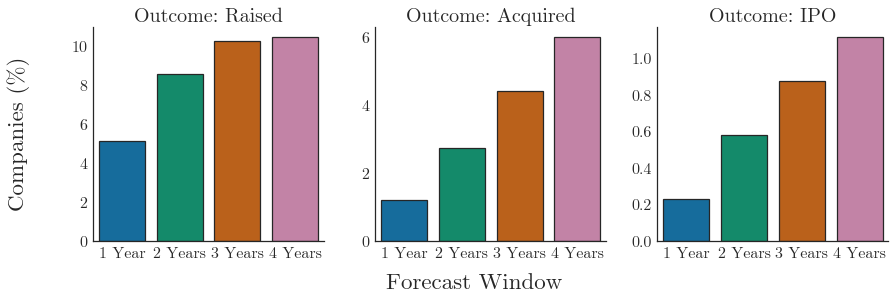

In [55]:
f = sns.factorplot(data=results, y = "Count", x = "forecast_window_years", col="Outcome", col_order=hue_order, sharey=False, kind="bar", **outline_bars)
f = f.set_axis_labels("", "")
f = f.set_titles(f_titles)
#helper.format_axis_ticks(f, axis="y", fmt="{:,}%")
plt.tight_layout()
f.fig.text(0.5, -0.04, x_label, ha='center',size=MEDIUM_SIZE+3)
f.fig.text(-0.04, 0.5, y_label, va='center', rotation='vertical',size=MEDIUM_SIZE+3)
#f = f.add_legend(title=leg_title)

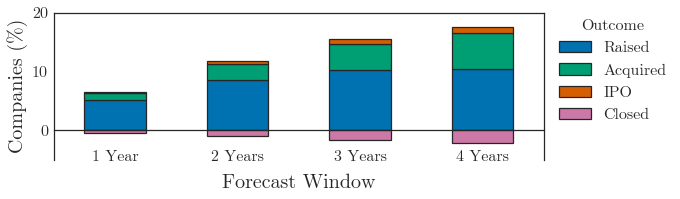

In [26]:
yo = results.groupby([x,hue])[y].sum()
ax = yo.unstack()[hue_order].plot(kind="bar",stacked=True, **outline_bars,zorder=-10)
f = plt.gcf()
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.spines['bottom'].set_position('zero')
ax.xaxis.labelpad = 10
ax.xaxis.set_tick_params(pad=20)
ax.set_ylim(ymin=-5, ymax=20)
plt.legend(bbox_to_anchor=(1,1.05), title=leg_title)
plt.tight_layout()

In [56]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Investment success by developmental stage

In [118]:
reload = True

In [119]:
chart_id = "figures/evaluation/outcomes_stage"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [120]:
def get_data():
    data = pd.read_pickle(SYS_PATH+"analysis/output/autoVC/17/merge_output.pkl")
    data["forecast_window"] = data["label_date"] - data["feature_date"]
    data["forecast_window_years"] = data["forecast_window"].apply(lambda x: x.days // 30) / 12
    data = data.loc[data["forecast_window_years"] > 0]
    data["outcome_extra_stage_number"] = data["outcome_stage_number"] - data["keys_company_stage_number"]
    data["outcome_extra_stage_bool"] = np.where(data["outcome_extra_stage_number"] > 0, 1, 0)
    data["Outcome"] = "No Change"
    data["Outcome"] = np.where((data["Outcome"] == "No Change") & (data["outcome_closed_bool"] >= 1), "Closed", data["Outcome"])
    data["Outcome"] = np.where((data["Outcome"] == "No Change") & (data["outcome_ipo_bool"] >= 1), "IPO", data["Outcome"])
    data["Outcome"] = np.where((data["Outcome"] == "No Change") & (data["outcome_acquired_bool"] >= 1), "Acquired", data["Outcome"])
    data["Outcome"] = np.where((data["Outcome"] == "No Change") & (data["outcome_extra_stage_bool"] >= 1), "Raised", data["Outcome"])
    data["Outcome"].value_counts()
    data = data[["Outcome", "keys_company_stage","forecast_window_years"]]
    return data

In [121]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = get_data()
    data.to_pickle(pickle_path)

In [122]:
x = "keys_company_stage"
y = "Count"
hue = "Outcome"
hue_order = ["Raised", "Acquired", "IPO", "Closed"]
x_label = "Initial Developmental Stage"
y_label = "Companies (%)"
leg_title = "Outcome"

In [123]:
results = data.groupby(x)[hue].value_counts(normalize=True).to_frame()
results = results.rename(index=str, columns={hue:"Count"})
results["Count"] = results["Count"] * 100
results = results.reset_index(drop=False)
results["Count"] = np.where(results["Outcome"] == "Closed", results["Count"] * -1, results["Count"])
results = results.groupby([x,hue])[y].sum()
results = results.unstack()[hue_order]

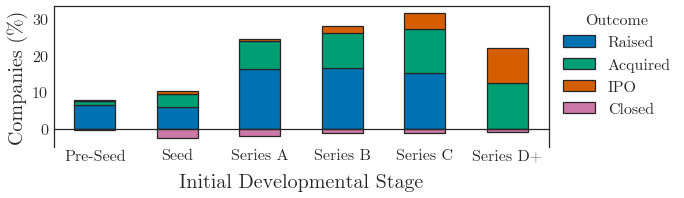

In [124]:
ax = results.plot(kind="bar",stacked=True, **outline_bars)
f = plt.gcf()
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.spines['bottom'].set_position('zero')
ax.xaxis.labelpad = 10
ax.xaxis.set_tick_params(pad=20)
ax.set_ylim(ymin=-5)
plt.legend(bbox_to_anchor=(1,1.05), title=leg_title)
plt.tight_layout()

In [108]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Dataset counts over time

In [23]:
reload = False

In [24]:
chart_id = "figures/design/counts_stage_slice"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [25]:
def get_data():
    data = pd.read_pickle(SYS_PATH+"analysis/output/autoVC/17/output.pkl")
    data["Slice"] = data["date"].apply(lambda x: x.year)
    return data

In [26]:
try: 
    if reload: data = pd.read_pickle(pickle_path)
    else: raise IOError
except IOError: 
    data = get_data()
    data.to_pickle(pickle_path)

In [27]:
x = "Slice"
y = "Count"
hue = "stage"
hue_order = ["Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+"]
x_label = "Slice Date"
y_label = "Companies"
leg_title = "Developmental Stage"

In [28]:
results = data.groupby(x)[hue].value_counts(normalize=False).to_frame()
results = results.rename(index=str, columns={hue:"Count"})
results["Count"] = results["Count"] / 1e3
results = results.reset_index(drop=False)
results = results.groupby([x,hue])[y].sum()
results = results.unstack()[hue_order]

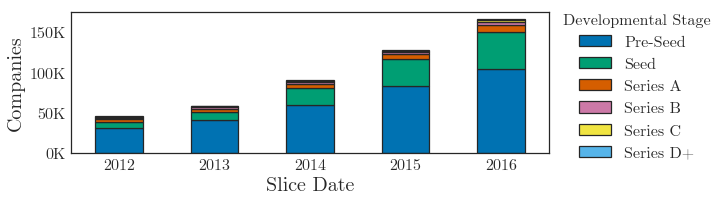

In [31]:
ax = results.plot(kind="bar",stacked=True, **outline_bars)
f = plt.gcf()
ax.set_yticklabels(["{:,.0f}K".format(ytick) for ytick in ax.get_yticks().tolist()])
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.spines['bottom'].set_position('zero')
plt.legend(bbox_to_anchor=(1,1.1), title=leg_title)
plt.tight_layout()

In [32]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Dataset slice compared to original database

In [68]:
chart_id = "figures/design/counts_slice_method"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [69]:
index=["People", "Companies", "Rounds", "Acquisitions", "IPOs"]

sliced = pd.DataFrame({"Counts":[216.146, 179.351,49.131,8.882,.790]}, index=index)
original = pd.DataFrame({"Counts": [226.709, 196.553,52.928,9.562,1.259]},index=index)

sliced["Method"] = "2013 Slice (from 2016 Database)"
original["Method"] = "2013 Original Database"
counts = pd.concat([sliced, original], axis=0)

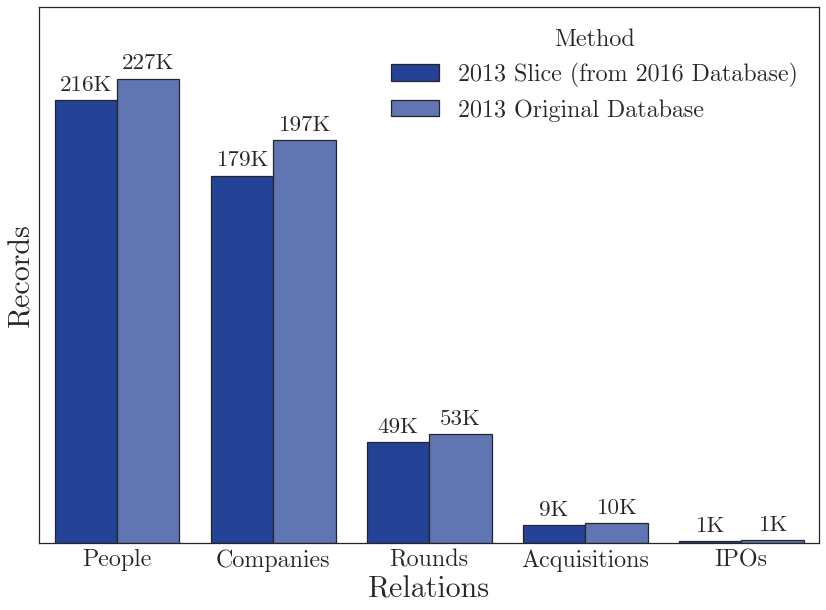

In [70]:
with sns.color_palette([palette[0], palette[2]]):
    f = plt.figure()
    ax = sns.barplot(x=counts.index, y=counts["Counts"], hue=counts["Method"],saturation=1, **outline_bars)
    helper.auto_label(ax, fmt='{:,.0f}K', size=SMALL_SIZE-1)
    ax.set_xlabel("Relations")
    ax.set_ylabel("Records")
    plt.legend(title="Method")#,bbox_to_anchor=(1,1.1), loc="upper left")
    plt.tight_layout()

In [56]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")

### Master database numbers by relation

In [18]:
chart_id = "figures/design/counts_relation_master"
pickle_path = "{}/{}.pkl".format(SAVE_PATH, chart_id)

In [38]:
index = ["Acquisitions", "Competitors", "Customers","Events", "Rounds", "Funds", "Investments", "Investors", "IPOs", "Jobs", "Organizations", "Patents", "People"]
counts = [27.857, 502.358, 251.337, 7.075, 142.711, 4.954, 216.873, 47.632, 7.001, 942.542, 470.783, 1500.238, 545.451]
counts = pd.DataFrame({"Records":counts}, index=index)
order= counts.sort_values(by="Records", ascending=False).index.tolist()

In [39]:
order

['Patents',
 'Jobs',
 'People',
 'Competitors',
 'Organizations',
 'Customers',
 'Investments',
 'Rounds',
 'Investors',
 'Acquisitions',
 'Events',
 'IPOs',
 'Funds']

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


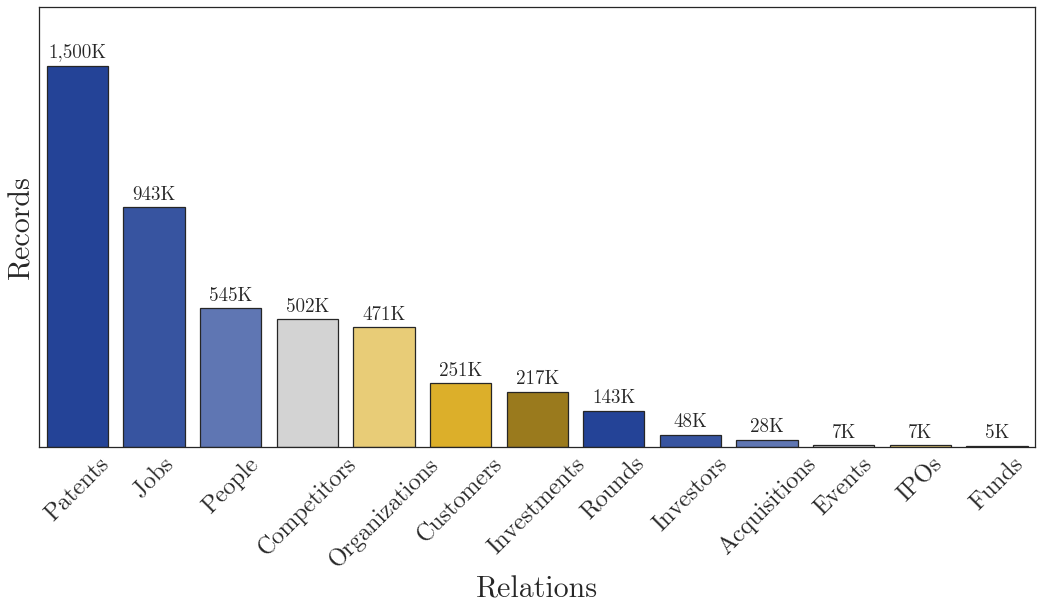

In [47]:
f = plt.figure()
ax = sns.barplot(x=counts.index, y=counts["Records"], order=order, saturation=1, **outline_bars)
helper.auto_label(ax, fmt='{:,.0f}K', size=SMALL_SIZE-5)
ax.set_xlabel("Relations")
ax.set_ylabel("Records")
plt.xticks(rotation=45)
plt.legend(title="Method")#,bbox_to_anchor=(1,1.1), loc="upper left")
plt.tight_layout()

In [10]:
output_path =  "{}/{}.pdf".format(SAVE_PATH, chart_id)
f.savefig(output_path, bbox_inches="tight")